(c) 2024 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Import project package
import Antibiotic

# Import project package
import AutoEncode

# Import libraries to handel data
import CSV
import DataFrames as DF
import Glob

# Import ML libraries
import Flux

# Import library to save models
import JLD2

# Import basic math
import StatsBase
import Random
Random.seed!(42)

# Import Plotting libraries
using CairoMakie
import ColorSchemes

# Activate backend
CairoMakie.activate!()

# Set Plotting style
Antibiotic.viz.theme_makie!()

# Exploratory data analysis of the RHVAE results

`[explanation here]`

Let's begin by listing the files with the saved model.

In [27]:
# List files in output directory
files = Glob.glob("output/model_state/*.jld2")

first(files, 5)

5-element Vector{String}:
 "output/model_state/rhvae_0.0001epsilon_epoch00001.jld2"
 "output/model_state/rhvae_0.0001epsilon_epoch00002.jld2"
 "output/model_state/rhvae_0.0001epsilon_epoch00003.jld2"
 "output/model_state/rhvae_0.0001epsilon_epoch00004.jld2"
 "output/model_state/rhvae_0.0001epsilon_epoch00005.jld2"

Now, let's loop through each file, and load the values of the loss function and
the mean squared error for each model.

In [28]:
# Initialize empty dataframe
df_train = DF.DataFrame()
# Define fields to keep
fields = ["mse_train", "mse_val", "loss_train", "loss_val"]

# Loop through files
for f in files
    # spit file name to extract beta value and epoch number
    pars = split(f, "_")[end-1:end]
    # Parse beta value
    ϵ = parse(Float64, replace(pars[1], "epsilon" => ""))
    # Parse epoch number
    epoch = parse(Int, replace(pars[2], ".jld2" => "", "epoch" => ""))
    # Load file and keep relevant fields
    file_load = JLD2.load(f)
    # Convert to dataframe
    df_tmp = DF.DataFrame(Dict(zip(fields, [file_load[x] for x in fields])))
    # Add beta and epoch to dataframe
    df_tmp[!, :step_size] .= ϵ
    df_tmp[!, :epoch] .= epoch

    # Append to main dataframe
    DF.append!(df_train, df_tmp)
end # for

# Sort by beta and epoch
DF.sort!(df_train, [:step_size, :epoch])

first(df_train, 5)

Row,loss_train,loss_val,mse_train,mse_val,step_size,epoch
,Float32,Float32,Float32,Float32,Float64,Int64
1,10.1308,10.7081,0.98859,1.05442,0.0001,1
2,10.2705,10.5409,0.987988,1.05312,0.0001,2
3,10.2239,10.4582,0.989855,1.05444,0.0001,3
4,10.2522,10.7204,0.985855,1.05377,0.0001,4
5,10.3066,10.307,0.991671,1.05019,0.0001,5


With this information we can then plot the loss function and the mean squared
error for each model.

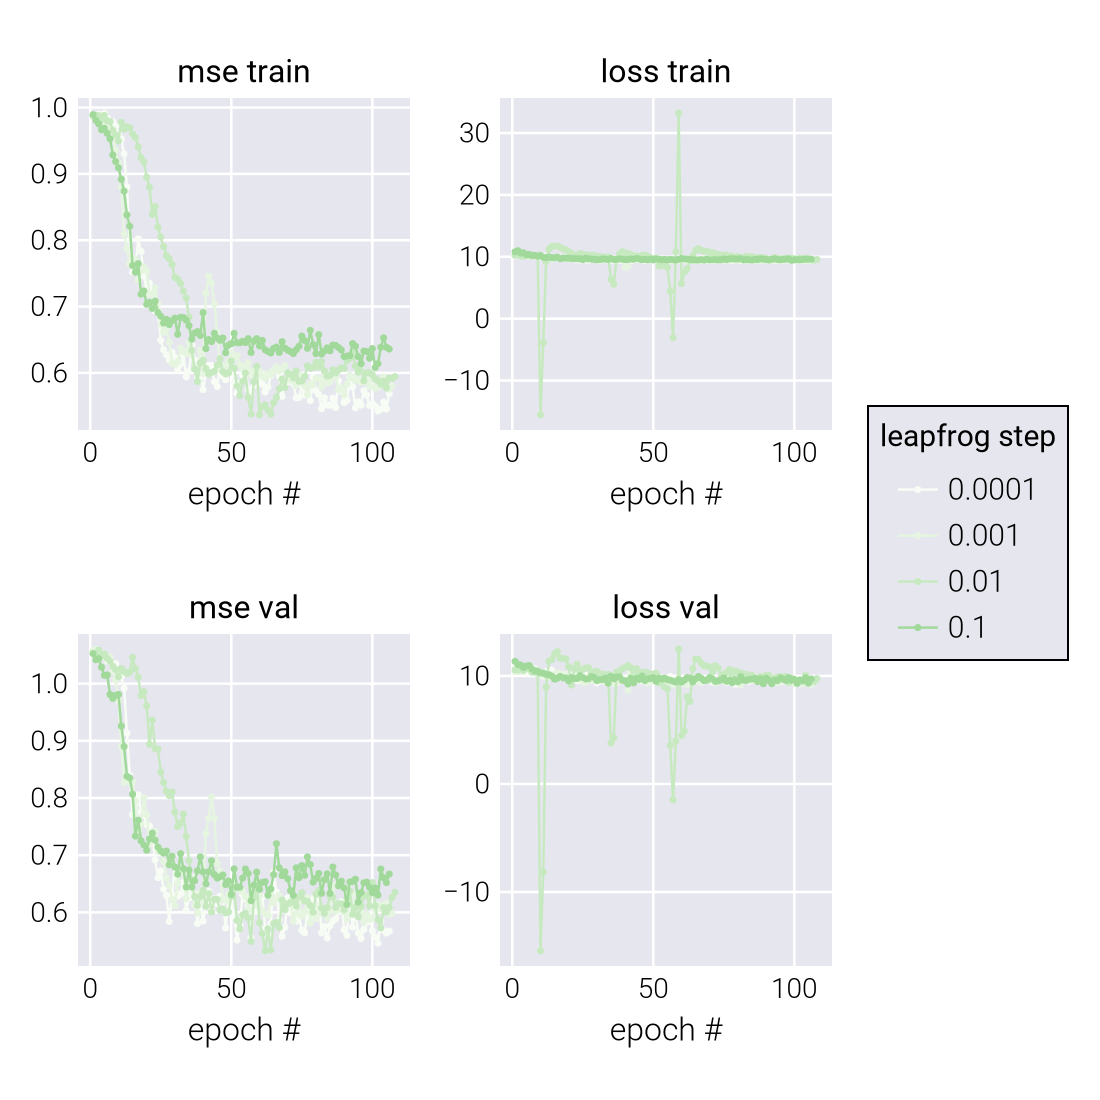

In [29]:
# Group data by β value
df_group = DF.groupby(df_train, :step_size)

# Initialize figure
fig = Figure(size=(550, 550))

# Add axes to figure
axes = [
    Axis(
        fig[i, j],
        aspect=AxisAspect(1),
        xlabel="epoch #",
    ) for i in 1:2, j in 1:2
]

# Loop through fields
for (i, field) in enumerate(fields)
    # Get axis
    ax = axes[i]
    # Loop through groups
    for (j, df) in enumerate(df_group)
        # Get x and y values
        x = df.epoch
        y = df[:, field]
        # Plot
        scatterlines!(
            ax, x, y, color=ColorSchemes.Greens[j], markersize=5,
            label="$(df.step_size[1])"
        )
    end # for
    # Set subplot title
    ax.title = replace(field, "_" => " ")
end # for

# Add legend to first subplot
Legend(fig[1:2, 3], axes[1], "leapfrog step", position=:rt)

fig

## Mapping points to latent space

The models at $10^{-3}$ and $10^{-4}$ step size seem to generalize the best.
Let's explore the latent space of these model.

In [30]:
# Define loss function hyper-parameters
K = 5 # Number of leapfrog steps
βₒ = 0.3f0 # Initial temperature for tempering

# Define ϵ values to load
ϵ = Float32.([1E-4, 1E-3])

# Initialize empty dictionary
rhvae_dict = Dict()

# Loop through ϵ values
for (i, ϵ) in enumerate(ϵ)
    # List files in output directory
    files = sort(
        Glob.glob("output/model_state/*$(ϵ)epsilon_epoch*.jld2")
    )
    # Load model
    rhvae_dict["$(ϵ)_model"] = JLD2.load("./output/model.jld2")["model"]
    # Load parameters
    model_state = JLD2.load(files[end])["model_state"]
    # Set model parameters
    Flux.loadmodel!(rhvae_dict["$(ϵ)_model"], model_state)
    # Update metric
    AutoEncode.RHVAEs.update_metric!(rhvae_dict["$(ϵ)_model"])
    # Define RHVAE hyper-parameters in a dictionary
    rhvae_dict["$(ϵ)_kwargs"] = Dict(
        :K => K,
        :ϵ => ϵ,
        :βₒ => βₒ,
        :∇H => AutoEncode.RHVAEs.∇hamiltonian_TaylorDiff,
        :∇H_kwargs => Dict(
            :momentum_logprior => AutoEncode.RHVAEs.riemannian_logprior_loop
        ),
    )
end # for

typeof(rhvae_dict["$(1E-4)_model"])

AutoEncode.RHVAEs.RHVAE{AutoEncode.VAEs.VAE{AutoEncode.JointLogEncoder, AutoEncode.SimpleDecoder}}

Let's load the data.

In [31]:
# Define data directory
data_dir = "$(git_root())/data/Iwasawa_2022"

# Load file into memory
df_ic50 = CSV.read("$(data_dir)/iwasawa_ic50_tidy.csv", DF.DataFrame)

# Locate strains with missing values
missing_strains = unique(df_ic50[ismissing.(df_ic50.log2ic50), :strain])

# Remove data
df_ic50 = df_ic50[[x ∉ missing_strains for x in df_ic50.strain], :]

# Group data by strain and day
df_group = DF.groupby(df_ic50, [:strain, :day])

# Extract unique drugs to make sure the matrix is built correctly
drug = sort(unique(df_ic50.drug))

# Initialize matrix to save ic50 values
ic50_mat = Matrix{Float32}(undef, length(drug), length(df_group))

# Loop through groups
for (i, data) in enumerate(df_group)
    # Sort data by stress
    DF.sort!(data, :drug)
    # Check that the stress are in the correct order
    if all(data.drug .== drug)
        # Add data to matrix
        ic50_mat[:, i] = Float32.(data.log2ic50)
    else
        println("group $i stress does not match")
    end # if
end # for

# Define number of environments
n_env = size(ic50_mat, 1)
# Define number of samples
n_samples = size(ic50_mat, 2)

# Fit model to standardize data to mean zero and standard deviation 1 on each
# environment
dt = StatsBase.fit(StatsBase.ZScoreTransform, ic50_mat, dims=2)

# Center data to have mean zero and standard deviation one
ic50_std = StatsBase.transform(dt, ic50_mat)

8×1269 Matrix{Float32}:
 -0.549695  -0.636041  -0.645549  …  -0.52737   -0.567254  -0.489156
  0.127085   0.396026   0.422921      0.152449   0.106901   0.0836802
 -0.952641  -0.814063  -0.947413     -0.712676  -0.723125  -0.706011
  0.434811  -0.480968  -0.244397      0.702219   0.484944   0.544966
 -0.469319  -0.463574  -0.461562     -0.450975  -0.278867  -0.296857
  0.689883   0.638487   0.126388  …   0.910045   0.774161   0.968758
  0.22606    0.13382    0.396659     -0.436597  -0.589569  -0.649776
 -0.605906  -0.748028  -0.533354     -0.860089  -1.17661   -0.934113

Now, let's encode the data using the model encoder to obtain the latent space
representation of the data.

In [32]:
# Loop through ϵ values
for ϵ in ϵ
    # Encode data to latent space
    rhvae_dict["$(ϵ)_latent"] = rhvae_dict["$(ϵ)_model"].vae.encoder(ic50_std).µ
end # for

rhvae_dict["$(1E-4)_latent"]

2×1269 Matrix{Float32}:
 -0.0819075  -0.132934  -0.176584  …  0.00780751  0.0011762  0.0656702
  0.217164    0.128484   0.181266     0.133206    0.0174526  0.024974

Let's plot the latent space representation of the data.

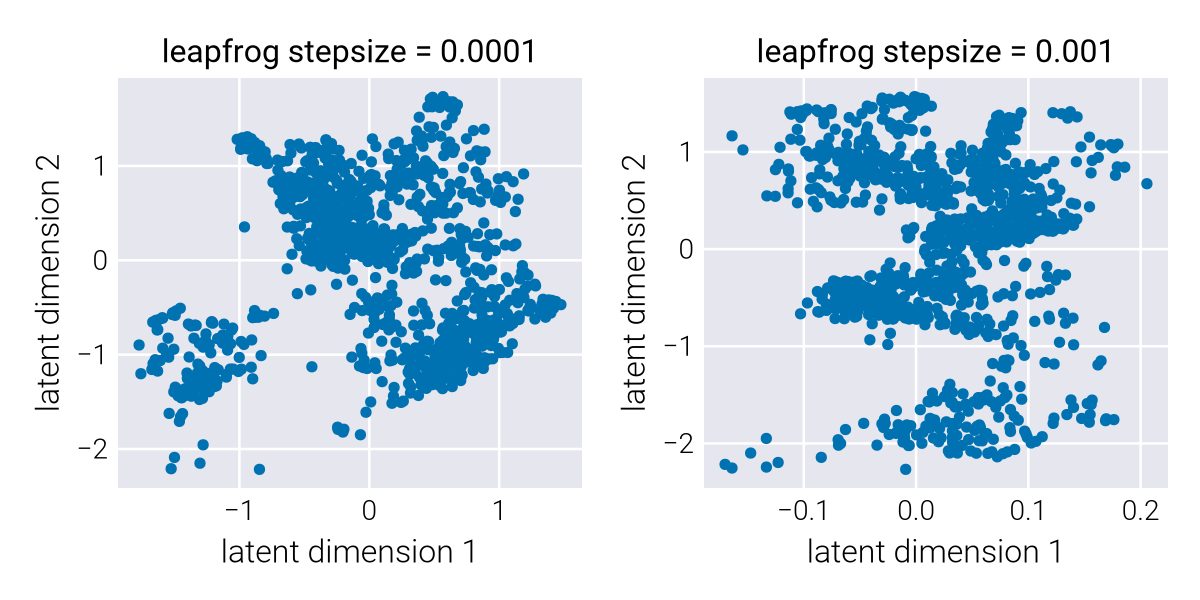

In [33]:
# Initialize plot
fig = Figure(size=(600, 300))

# Add axis to plot
ax = [
    Axis(
        fig[1, i],
        xlabel="latent dimension 1",
        ylabel="latent dimension 2",
    ) for i in 1:length(ϵ)
]

# Loop through ϵ values
for (i, ϵ) in enumerate(ϵ)
    # Add scatter plot to axis
    scatter!(
        ax[i],
        rhvae_dict["$(ϵ)_latent"][1, :],
        rhvae_dict["$(ϵ)_latent"][2, :],
        markersize=8,
        label="$(ϵ) epsilon"
    )

    # Add title to axis
    ax[i].title = "leapfrog stepsize = $(ϵ)"
end # for

fig

There is some interesting structure with isolated clusters of points. But,
without a metric or a decoder uncertainty, the interpolation between points is
not very informative. Let's compute the metric for a grid of points in latent
space

In [34]:
# Define number of points per axis
n_points = 200

# Define range of latent space
latent_range = Float32.(range(-3, 3, length=n_points))

# Define latent points to evaluate
z_mat = reduce(hcat, [[x, y] for x in latent_range, y in latent_range])

# Loop through ϵ values
for (i, ϵ) in enumerate(ϵ)
    # Compute inverse metric tensor
    Ginv = AutoEncode.RHVAEs.G_inv(z_mat, rhvae_dict["$(ϵ)_model"])
    # Compute log determinant of metric tensor
    rhvae_dict["$(ϵ)_logdetG"] = reshape(
        -1 / 2 * AutoEncode.utils.slogdet(Ginv), n_points, n_points
    )
end # for

rhvae_dict["$(1E-4)_logdetG"]

200×200 Matrix{Float64}:
 4.59916  4.59853  4.59785  4.59711  …  4.60514  4.60515  4.60515  4.60515
 4.59823  4.5975   4.59671  4.59585     4.60514  4.60514  4.60515  4.60515
 4.59717  4.59633  4.59542  4.59443     4.60513  4.60514  4.60514  4.60515
 4.59598  4.59501  4.59396  4.59283     4.60512  4.60513  4.60514  4.60514
 4.59464  4.59353  4.59233  4.59104     4.60511  4.60512  4.60513  4.60514
 4.59314  4.59187  4.5905   4.58903  …  4.6051   4.60511  4.60512  4.60513
 4.59146  4.59002  4.58846  4.58678     4.60509  4.6051   4.60511  4.60512
 4.58959  4.58796  4.58619  4.58429     4.60507  4.60509  4.6051   4.60511
 4.58752  4.58567  4.58368  4.58152     4.60505  4.60507  4.60509  4.6051
 4.58523  4.58315  4.5809   4.57847     4.60503  4.60505  4.60507  4.60509
 ⋮                                   ⋱                             
 4.60511  4.6051   4.60509  4.60507     4.60509  4.6051   4.60511  4.60512
 4.60512  4.60511  4.6051   4.60509     4.6051   4.60511  4.60512  4.60513
 4.60513

Now, let's repeat the plot of latent space representation, but this time with
the metric as the background color.

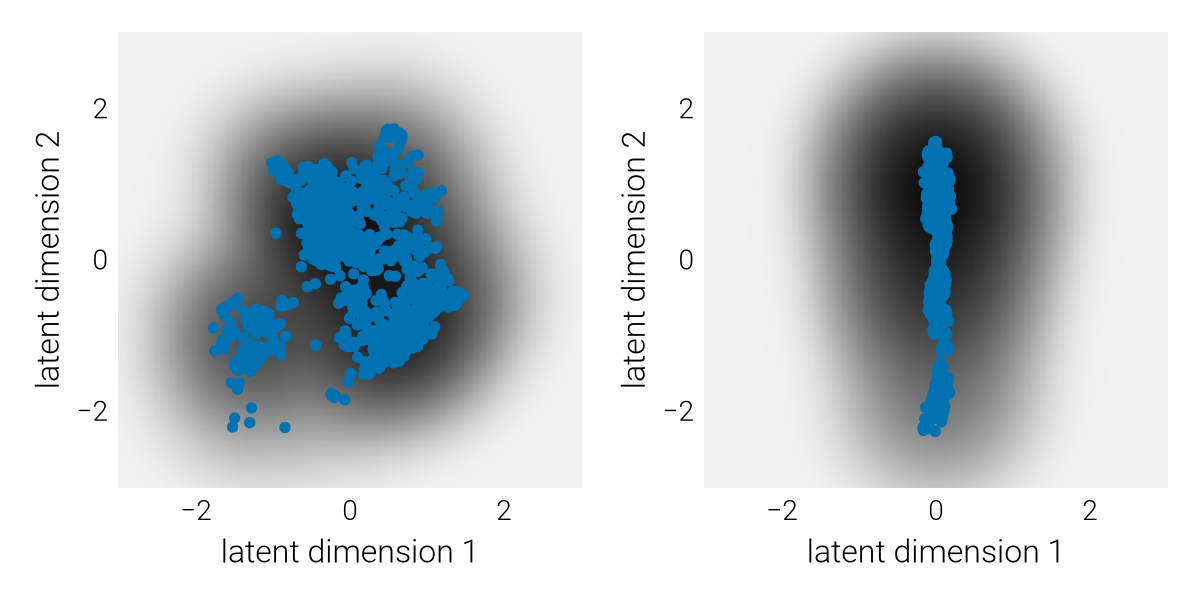

In [35]:
# Initialize figure
fig = Figure(size=(600, 300))

# Add axis to plot
ax = [
    Axis(
        fig[1, i],
        xlabel="latent dimension 1",
        ylabel="latent dimension 2",
    ) for i in 1:length(ϵ)
]

# Loop through ϵ values
for (i, ϵ) in enumerate(ϵ)

    # Plot heatmap of log determinant of metric tensor
    hm = heatmap!(
        ax[i],
        latent_range,
        latent_range,
        rhvae_dict["$(ϵ)_logdetG"],
        colormap=:grays
    )

    # Add colorbar to figure
    # fig[1, 2] = Colorbar(fig, hm, label="log(√det(G))")

    # Add scatter plot to axis
    scatter!(
        ax[i],
        rhvae_dict["$(ϵ)_latent"][1, :],
        rhvae_dict["$(ϵ)_latent"][2, :],
        markersize=8,
    )

end # for

fig

Let's extract these latent space representations and append the corresponding
metadata.

In [130]:
# Extract strains as ordered in ic50 matrix
strains_mat = [x.strain for x in keys(df_group)]
day_mat = [x.day for x in keys(df_group)]

# Generate dataframe with corresponding metadata
df_meta_mat = DF.DataFrame(
    strain=strains_mat,
    day=day_mat,
    z1=latent_train[1, :],
    z2=latent_train[2, :],
)

# Add corresponding metadata resistance value
df_meta_mat = DF.leftjoin!(
    df_meta_mat,
    unique(df_ic50[:, [:strain, :day, :parent, :env]]),
    on=[:strain, :day]
)

first(df_meta_mat, 5)

Row,strain,day,z1,z2,parent,env
,String31,Int64,Float32,Float32,String7,String7
1,Parent in TET 1,1,-0.252413,-0.338945,Parent,TET
2,Parent in TET 1,2,-0.743942,-0.115918,Parent,TET
3,Parent in TET 1,3,-0.809301,-0.0511692,Parent,TET
4,Parent in TET 1,4,-1.44415,-0.535986,Parent,TET
5,Parent in TET 1,5,-0.813982,-0.420117,Parent,TET


We can now repeat the same plot as above, but this time coloring each point by
their strain.

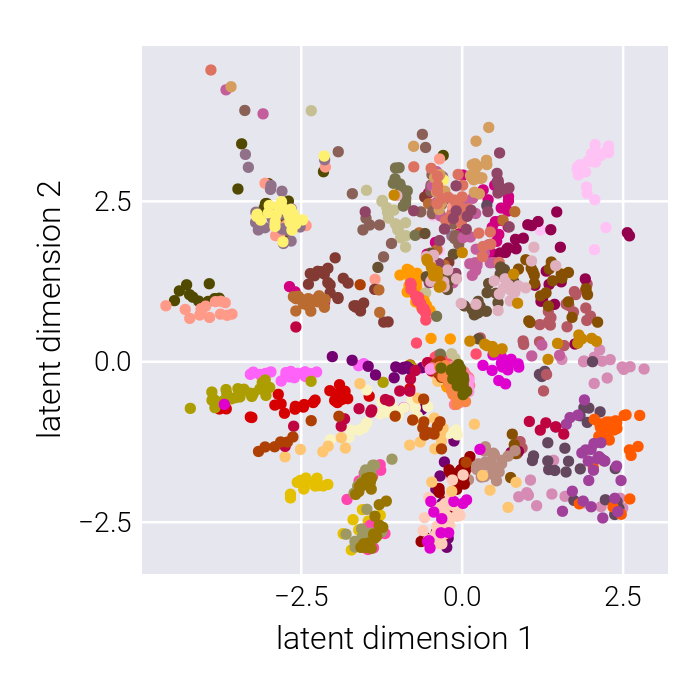

In [131]:
# Initialize figure
fig = Figure(size=(350, 350))

# Add axis to figure
ax = Axis(
    fig[1, 1],
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
    aspect=AxisAspect(1)
)

# Group data by resistance
df_group = DF.groupby(df_meta_mat, :strain)

# Loop through groups
for (i, data) in enumerate(df_group)
    # Add scatter plot to axis
    scatter!(
        ax,
        data.z1,
        data.z2,
        markersize=8,
        label=data.strain[1],
        color=ColorSchemes.glasbey_bw_minc_20_hue_330_100_n256[i],
    )
end

fig

Let's repeat this process but this time coloring the points by the environment
(antibiotic) in which they evolved.

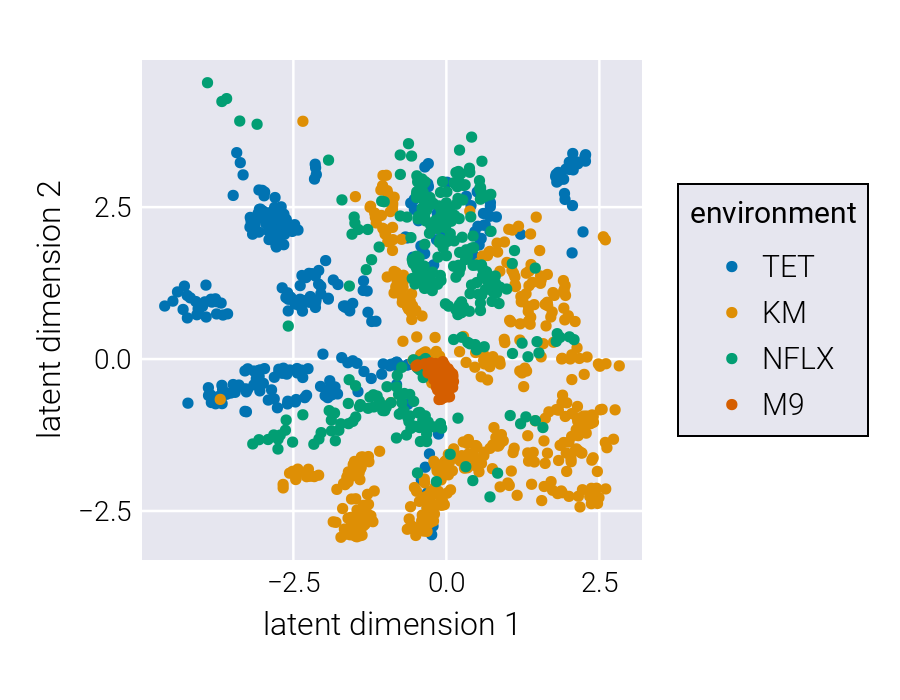

In [132]:
# Initialize figure
fig = Figure(size=(450, 350))

# Add axis to figure
ax = Axis(
    fig[1, 1],
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
    aspect=AxisAspect(1)
)

# Group data by resistance
df_group = DF.groupby(df_meta_mat, :env)

# Loop through groups
for (i, data) in enumerate(df_group)
    # Add scatter plot to axis
    scatter!(
        ax,
        data.z1,
        data.z2,
        markersize=8,
        label=data.env[1],
        color=ColorSchemes.seaborn_colorblind[i],
    )
end

# Add legend to axis
fig[1, 2] = Legend(fig, ax, "environment")

fig

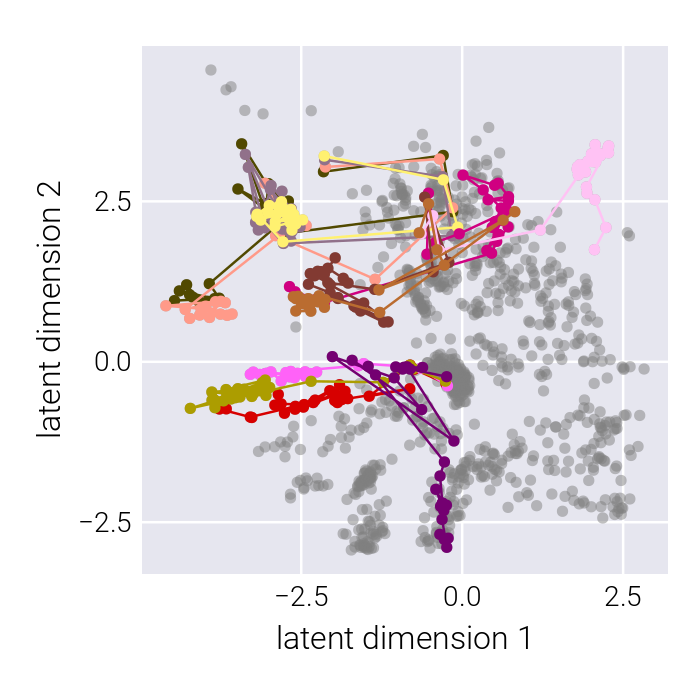

In [148]:
# Initialize figure
fig = Figure(size=(350, 350))

# Add axis to figure
ax = Axis(
    fig[1, 1],
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
    aspect=AxisAspect(1)
)

# Add scatter plot to axis
scatter!(
    ax,
    latent_train[1, :],
    latent_train[2, :],
    markersize=8,
    color=(:gray, 0.5)
)

# Group data by resistance
df_group = DF.groupby(
    df_meta_mat[df_meta_mat.env.=="TET", :], :strain
)

# colors = [:viridis, :inferno, :plasma]

# Loop through groups
for (i, data) in enumerate(df_group)
    # Order data by day
    DF.sort!(data, :day)

    # Add scatter plot to axis
    scatterlines!(
        ax,
        data.z1,
        data.z2,
        markersize=8,
        color=ColorSchemes.glasbey_bw_minc_20_hue_330_100_n256[i],
    )
end

fig